In [1]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy 
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

from qiskit import QuantumCircuit
#from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

torch.backends.cudnn.benchmark = True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

directory = 'baseline_results/'
experiment_id = 'finish/'

agent_id = 2

cpu


In [3]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cpu'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        
        return torch.Tensor(states).type(torch.float).to(device), torch.Tensor(actions).type(torch.long).to(device), torch.Tensor(next_states).to(device), torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

In [4]:
num_qubits = 4

def create_qnn():
    n_qubits = int(num_qubits/2)

    qc = QuantumCircuit(n_qubits)
    feature_map = ZFeatureMap(n_qubits)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn


qnn = create_qnn()


print("QNN Training Parameters: ", qnn.num_weights)
print(qnn.circuit.draw())

QNN Training Parameters:  4


/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_18329/4123833481.py:14: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


     ┌─────────────────────────┐┌──────────────────────────────────────┐
q_0: ┤0                        ├┤0                                     ├
     │  ZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                        ├┤1                                     ├
     └─────────────────────────┘└──────────────────────────────────────┘


In [5]:
class conv_nn(nn.Module):
    
    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        


        

        self.linear = nn.Sequential(nn.LazyLinear( num_qubits//2),
                                    TorchConnector(qnn),
                                    nn.LazyLinear(4, n_act),
                                   )

        
        
        
    def forward(self, x1):
    
        x1 = x1.view(len(x1), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x1).view(len(x1),-1)
    
        out_lin = self.linear(out_conv)
        
        return out_lin

   

In [6]:
def get_qvalues(state, model):
    state = torch.Tensor(state).to(device)
    qvalues = model(state)
    return qvalues

In [7]:
def plot_policy_map(agent, model, get_qvalues, filename, offset):

    with torch.no_grad():
        # Create two independent figures
        fig, ax = plt.subplots()
        ax.imshow(agent.env.maze, 'Greys')

        for free_cell in agent.env.allowed_states:
            agent.env.current_position = np.array(free_cell)
            

            # Get Q-values for both agents
            qvalues= get_qvalues(torch.Tensor(agent.env.state()).view(1, -1).to('cpu'), model)

            # Get best actions
            action = int(torch.argmax(qvalues).detach().cpu().numpy())
            policy = agent.env.directions[action]


            # Add policy text to both figures
            ax.text(free_cell[1] - offset[0], free_cell[0] - offset[1], policy)
            
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Save images
        plt.figure(fig.number)  # Activate first figure
        plt.savefig(directory + experiment_id + filename, dpi=300, bbox_inches='tight')

        # Show both figures
        plt.show()

In [8]:
def Qloss(batch, model, gamma=0.99, device="cpu"):
    # Unpack the batch
    states, actions, next_states, rewards, _ = batch

    # Move data for both agents to the desired device
    states = states.to(device)
    actions = actions.to(device)
    next_states = next_states.to(device)
    rewards = rewards.to(device)
    
    # Convert states and next_states to NumPy arrays
    states = states.cpu().detach().numpy()
    next_states = next_states.cpu().detach().numpy()
    

    # Create PyTorch tensors from the NumPy arrays
    states_tensor = torch.from_numpy(states).to(device)
    next_states_tensor = torch.from_numpy(next_states).to(device)

    # Get the number of samples in the batch
    lbatch = len(states_tensor)

    # Get the Q-values for the current states
    state_action_values = get_qvalues(states_tensor.view(lbatch,-1), model)

    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    
    # Get the Q-values for the next states
    next_state_values = get_qvalues(next_states_tensor.view(lbatch, -1), model)

    next_state_values = next_state_values.max(1)[0]
    next_state_values = next_state_values.detach()

    # Compute the expected Q-values
    expected_state_action_values = next_state_values * gamma + rewards  

    return nn.MSELoss()(state_action_values, expected_state_action_values)
    

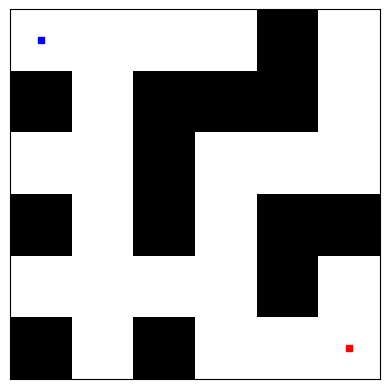

In [9]:
from environment import MazeEnvironment

row_num = 6
col_num = 6

maze = np.load('./maze_generator/maze_' + str(row_num) + 'x' + str(col_num) + '.npy')

start_position =0
end_position = 0
if agent_id == 1:
    start_position = [0,0]
    end_position = [len(maze)-1, len(maze)-1] 
elif agent_id == 2:
    start_position = [len(maze)-1, len(maze)-1]
    end_position = [0,0]
else: 
    print('Error')
    exit()

maze_env = MazeEnvironment(maze, start_position, end_position)

maze_env.draw(directory + 'maze.png')

In [10]:
buffer_capacity = 10000
buffer_size = 1000

memory_buffer = ExperienceReplay(buffer_capacity)

In [11]:
from agent import Agent


agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
             )


In [12]:
net = conv_nn(row_num, col_num, 4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

batch_size = 24
gamma = 0.9
net.to(device)


conv_nn(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (linear): Sequential(
    (0): LazyLinear(in_features=0, out_features=2, bias=True)
    (1): TorchConnector()
    (2): LazyLinear(in_features=0, out_features=4, bias=True)
  )
)

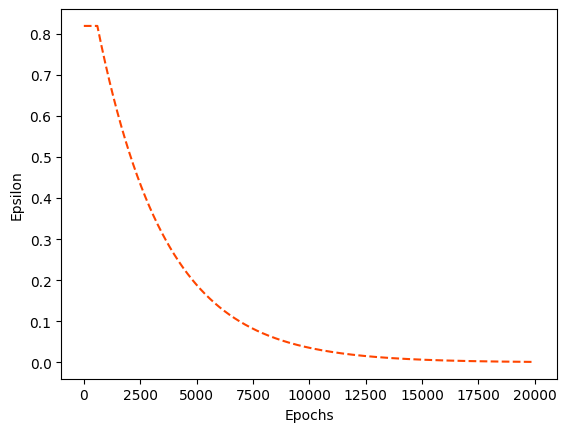

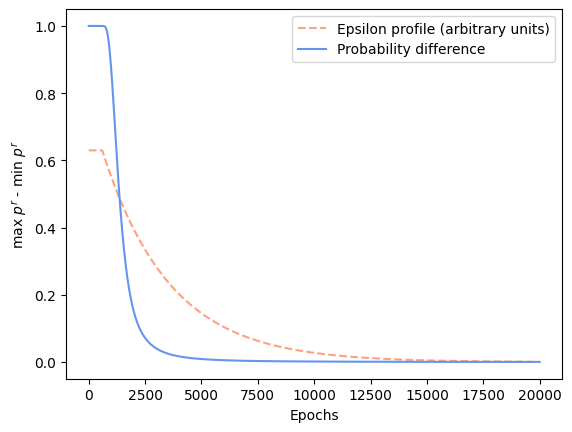

In [13]:
num_epochs = 20000

cutoff = 3000
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig(directory +'reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [14]:
def contains(list, object):
    for item in list:
        if (item == object).all():
            return True
    
    return False
def equal(a, b):
    if len(a) != len(b):
        print("Lengths are not equal")
        print("Length of a: ", len(a))
        print("Length of b: ", len(b))
    
        return False
    for i in range(len(a)):
        if a[i] != b[i]:
            return False
    return True

In [15]:
def plot_loss(losses):
    plt.plot(losses,  label = 'Loss', color = 'orangered')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(directory + experiment_id + 'loss.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()

def plot_reward(rewards):
    plt.plot(rewards,  label = 'Reward', color = 'orangered')
    plt.xlabel('Epochs')
    plt.ylabel('Reward')
    plt.savefig(directory + experiment_id + 'reward.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()

def plot_winrate(winrate):
    plt.plot(winrate, label = 'Agent 1', color = 'cornflowerblue')
    plt.xlabel('Epochs')
    plt.ylabel('Win Rate')
    plt.legend()
    plt.savefig(directory + experiment_id + 'winrate.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()

In [16]:
def state_update(action):
    is_game_on = True

    # Initialize reward, each move costs 0.05
    reward = -.05

    move = agent.env.action_map[action]
    next_position = agent.env.current_position + np.asarray(move)

    if (agent.env.current_position == agent.env.goal).all():
        is_game_on = False
        reward = 1

        return (agent.env.state(), reward, is_game_on)
    else:
        if tuple(agent.env.current_position) in agent.env.visited:
            reward = -0.2

    if agent.env.is_state_valid(next_position):
        agent.env.current_position = next_position
    else:
        reward = -1
    agent.env.visited.add(tuple(agent.env.current_position))

    return (agent.env.state(), reward, is_game_on)


    

In [17]:
def get_reward(agent):
    agent.env.current_position = np.asarray(start_position)
    counter = 0
    reward1 = 0
    
    while counter < 100:
        
        # Get the current state
        state1 = torch.tensor(agent.env.state()).view(1,-1).float()
       
        # Get the Q-values
        qvalues1 = get_qvalues(state1, net)
        
        if not equal(agent.env.current_position, agent.env.goal):
            action1 = max(0, int(torch.argmax(qvalues1).detach().cpu().numpy()))
            update1 = state_update(action1)
            reward1 += update1[1]

        counter += 1
 
    return reward1

    

In [18]:
loss_log = []
reward_log = []
best_loss = 100000

running_loss = 0
win_counter = 0
win_total_log = []

estop = 0

for epoch in range(num_epochs):
    loss = 0
    counter = 0

    eps = epsilon[epoch]

    agent.isgameon = True
    agent.env.reset(eps)

    while agent.isgameon:
        # Get the current state
        current_state = agent.env.state()
        state = torch.tensor(current_state).view(1,-1).float()

        # Get the Q-values for the current state
        qvalues = get_qvalues(state, net)

        # Select an action
        action = agent.select_action(qvalues, eps, device= device)

        # Update the state
        update = state_update(action)

        # Store the transition
        agent.make_a_move(qvalues, eps, update, action, current_state)

        if len(agent.buffer) < buffer_size:
            continue
        
        # Sample a batch of transitions
        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device= device)

        # Compute the loss
        loss_t = Qloss(batch, net,gamma= gamma, device =device)

        # Backpropagate the loss
        loss_t.backward()
        optimizer.step()

        # Update the running loss
        loss += loss_t.item()
        counter += 1

    if epoch > 2000:
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss :
            best_loss = running_loss
            torch.save(net.state_dict(), directory + experiment_id + 'model_best_loss.pth')
            estop = epoch

    loss_log.append(loss)
        
    result = 'Lost'
    if (agent.env.current_position == agent.env.goal).all():
        win_counter += 1
        result = 'Won'
    win_total_log.append(win_counter/(epoch + 1))

    filename = 'sol_epoch_' + str(epoch)

    if epoch % 100 == 0:
        reward = get_reward(agent)
        reward_log.append(reward)
        if reward >= 0:
            torch.save(net.state_dict(), directory + experiment_id + 'best_model_reward.pth')


    if(epoch % 100 == 0 and epoch <= 2000) or (epoch % 1000 == 0):
        plot_policy_map(agent, net, get_qvalues, filename, offset = [0.35, -0.3])
        plot_loss(loss_log)
        plot_reward(reward_log)
        plot_winrate(win_total_log)

    clear_output(wait=True)
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)

    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if (epoch > 2000):
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop )
    




Epoch 19999 (number of moves 2)
Game Won
[####################################################################################################]
	 Average loss: 0.00044
	 Best average loss of the last 50 epochs: 0.00001, achieved at epoch 13330
